#**Upravljanje multi-agentnim sustavima**

(verzija od 19.svi 2023.)

* koristimo Schurovu dekompoziciju za ortogonalni komplement od jezgre od $L$
* Plotamo vrijednost $||F_i(s)||$
* Koristi se samo sustav dimenzije $n$ (dimenzija Laplaceove matrice grafa) 
* Uvodimo 4 različite klase grafova na kojima ćemo testirati vrijedsnot $||F_i(s)||$


##**Raspisano**
Računamo vrijednost funkcije $F_i(s)$:
\begin{align*}
         F_i(s)  & = \frac{1}{is\alpha + \gamma}VV^T(L-\mu(s)I)^{-1}e_i \\
         & = \left[\: L = ZTZ^T \: \right]\\
         & = \frac{1}{is\alpha + \gamma}VV^TZ(T-\mu(s)I)^{-1}Z^*e_i  \\
         & = \left[ \: VV^TZ = VV^T[\:W \:\: V \:] = V \left[\:0 \: \: I\: \right]  \right] \\
         & = \frac{1}{is\alpha + \gamma}\left[\:0_{n×k} \:\: V \:\right](T-\mu(s)I)^{-1}Z^*e_i\\
         & = \left[\: Z^*e_i = [Z_0 Z_1]^T, \: \: Z_0 \in M_{k,1}, Z_1 \in M_{n-k,1}\: \right]\\
         & = \frac{1}{is\alpha + \gamma} V (T_{22} - \mu(s)I)^{-1} Z_1
\end{align*}

Za $L$ koristimo Schurovu dekompoziciju za $L= ZTZ^T$, $Z= [\: W\:\: V\:],$ $ \: W \in M_{n,k},$ $ \: V \in M_{n,n-k},$ gdje su V stupci od $Z$ koji pripadaju ne-nul elementima i dolazimo do oblika za $\Phi$ (jer vrijedi $L = L V V^T$):

$$\Phi(s) = \left(is \alpha + \gamma \right)\left(\frac{is\beta -s^2}{is \alpha + \gamma}I +L\right) = \\ =  (is \alpha + \gamma)\left(L - \mu(s)I\right),$$
gdje je $\mu(s) =\frac{is\beta -s^2}{is \alpha + \gamma} $.

Za vrijednost u $0$:
$$F_i(0) = \frac{1}{\gamma}V(V^TLV)^{-1}V^Te_i,$$ iskoristi se Schur za L i def za V pa se dobije
$$F_i(0) = \frac{1}{\gamma}VT_{22}^{-1}V^Te_i, $$
gdje je $$ T = 
\begin{bmatrix}
  T_{11} & T_{12}\\
  0 & T_{22}
  \end{bmatrix}.
$$ Pritom blok matrica $T_{11} \in M_{k,k}$ na dijagonali ima $0$, a $T_{22} \in M_{n-k,n-k}$ ima ne-nul svojstvene vrijednosti.




In [83]:
import networkx as nx

import numpy as np
from scipy.sparse import csgraph
import scipy.signal as signal
import scipy.linalg as la
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math
import time

###**`Laplace_inDegree`**
*   za graf G vraća Laplacian u željenoj formi.

In [84]:
def _Laplace_inDegree(G):
  A = nx.adjacency_matrix(G)
  A = np.transpose(A)
  D = np.diag(A @ np.ones(np.size(A,1)).transpose())
  return D-A;

##**`mu_`**
* input: $\alpha, \beta, \gamma$
*output: funkcija ovisna o parametru $s$:  $$\mu(s)=\frac{is\beta -s^2}{is \alpha + \gamma} $$

In [85]:
def mu_(alpha, beta, gamma):
    def mu(s):
        return (s*s-1j*s*beta)/(gamma + 1j*alpha*s);
    return mu;

###**`get_Fi`**
*   za graf $G$, parametre $\alpha, \beta, \gamma$, računa $Schurovu$ dekompoziciju inDegree Laplaceove matrice grafa, vraća ugnježdenu funkciju koja prima komponentu $i$ i dimenziju jezgre Laplaceove matrice grafa.

* pritom se kod računanja koristi `scipy.linalg.solve_triangular` koja poziva `LAPACK` rutinu za trokutasti linearni sustav jedndadžbi

Primjer poziva:

```
sys_f, Kernel_dim, ndim = get_Fi(G,alpha,beta,gamma)
Fi = sys_f(i)
print(Fi(5))
```




In [104]:
L = _Laplace_inDegree(G)
ndim = np.shape(L)[0];
T,Z,dim_Ker_L = la.schur(L, sort = lambda x: abs(x)<1e-12)
print(np.shape(T),dim_Ker_L, np.shape(Z[dim_Ker_L:,3]))
print(np.max(np.diag(T)))

(60, 60) 42 (18,)
20.0


In [87]:
sys_f, Kernel_dim, ndim = get_Fi_norm(G,1,1,1)
Fi = sys_f(2)
print(Fi(5))

Računam Schurovu dekompoziciju
0.008693432668421519


In [106]:
def get_Fi_norm(G,alpha,beta,gamma):
    L = _Laplace_inDegree(G)
    ndim = np.shape(L)[0];
    T,Z,dim_Ker_L = la.schur(L, sort = lambda x: abs(x)<1e-12)
    max_diagonal = np.max(np.diag(T))
    print("Računam Schurovu dekompoziciju")
    V = Z[:,dim_Ker_L:]
    M = mu_(alpha,beta,gamma)
    EYE = np.diag(np.ones(ndim - dim_Ker_L))
    alpha_2 = alpha*alpha
    gamma_2 = gamma*gamma
    def FF_(i):
        VTei = V.T.conj()[:,i-1]
        Z_Tei = Z.T.conj()[dim_Ker_L:,i-1]
        def Fi(s):
            if (s == 0):
                #A = T[dim_Ker_L:,dim_Ker_L:] #uzmemo T_22
                x = la.solve_triangular(T[dim_Ker_L:,dim_Ker_L:],VTei)  #solve_triangular poziva
                #LAPACK rutinu za trokutasti sustav
                nrm =la.norm(V @ x /gamma)
                F = nrm
            else:
                x = la.solve_triangular(T[dim_Ker_L:,dim_Ker_L:] - EYE*M(s),Z_Tei)
                F = la.norm(V @ x)/np.sqrt(s*s*alpha_2 + gamma_2)
            return F;
        return Fi;
    return FF_, dim_Ker_L, ndim, max_diagonal;

#**Poziv nekog grafa G:**

[Dokumentacija](https://networkx.org/documentation/stable/reference/generators.html#module-networkx.generators.directed) za generatore grafova.

In [89]:
A = nx.gnr_graph(60, 0.5)
B = nx.gnc_graph(60)
D = nx.gn_graph(60)
G = nx.gn_graph(60, kernel=lambda x: x ** 1.5)
C = nx.random_k_out_graph(60, 4, 50.0, self_loops=False, seed=None)


## Naći max od $H_\infty$: (npr. pomoću Nelder-Mead)

Računanje $max_{\omega \in \mathbb{R}} \overline{\sigma}(\hat{F}(j\omega))$

Računamo normu od:

$F_i(s) = VV^T \Phi(s)^{-1}e_i$

$F_i(0) = \frac{1}{\gamma}V (V^TLV)^{-1}V^Te_i$

$||F_i(s)||^2_\infty = sup_s||F_i(s)||^2_2 = sup_s ||VV^T \Phi(s)^{-1}e_i||^2_2$

In [90]:
D = nx.gn_graph(60, kernel=lambda x: x ** 1.5)

Ovdje koristimo funkciju koja vraća normu vektora $F_i(s)$ pa je funkcija cilja u optimizaciju norma tog vektora.

U varijablu L_sigma spremimo najveću svojstvenu vrijednost.

In [91]:
def obj_fun(s):
    return -Fi(s)

In [107]:
alpha=1
beta=1
gamma=1


Graph = D
sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(Graph,alpha,beta,gamma)

x0 = 0.1
left_end = 0
right_end = L_sigma*10
spacing = 0.1
bounds = [(left_end,right_end)]
s_range = np.arange(left_end,right_end, spacing)

obj_values = []
norm_values = []
norm0_values = []
start_time = time.time()
print("Trajanje Schurove dekompozicije:", time.time()-start_time)
for i in range(ndim):
    now = time.time()
    Fi = sys_f(i)
    res = minimize(obj_fun, x0, bounds=bounds, method='Nelder-Mead')
    #print(res)
    s_opt = res.x[0]
    norm = -res.fun
    norm_0 = la.norm(Fi(0))
    #print(res.x, norm, "0",norm_0)
    obj_values.append([la.norm(Fi(s)) for s in s_range])
    norm_values.append(norm)
    norm0_values.append(norm_0)
    print("Trajanje ",i,"-te iteracije:", time.time()-now)
end_time = time.time()
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

Računam Schurovu dekompoziciju
Trajanje Schurove dekompozicije: 0.0010051727294921875
Trajanje  0 -te iteracije: 0.06791400909423828
Trajanje  1 -te iteracije: 0.06258702278137207
Trajanje  2 -te iteracije: 0.08468246459960938
Trajanje  3 -te iteracije: 0.06622052192687988
Trajanje  4 -te iteracije: 0.06249880790710449
Trajanje  5 -te iteracije: 0.0625002384185791
Trajanje  6 -te iteracije: 0.08005475997924805
Trajanje  7 -te iteracije: 0.06250476837158203
Trajanje  8 -te iteracije: 0.06249427795410156
Trajanje  9 -te iteracije: 0.0781242847442627
Trajanje  10 -te iteracije: 0.06276822090148926
Trajanje  11 -te iteracije: 0.06257891654968262
Trajanje  12 -te iteracije: 0.08463621139526367
Trajanje  13 -te iteracije: 0.06735944747924805
Trajanje  14 -te iteracije: 0.0729978084564209
Trajanje  15 -te iteracije: 0.06343793869018555
Trajanje  16 -te iteracije: 0.06571245193481445
Trajanje  17 -te iteracije: 0.08635354042053223
Trajanje  18 -te iteracije: 0.06339740753173828
Trajanje  19 -t

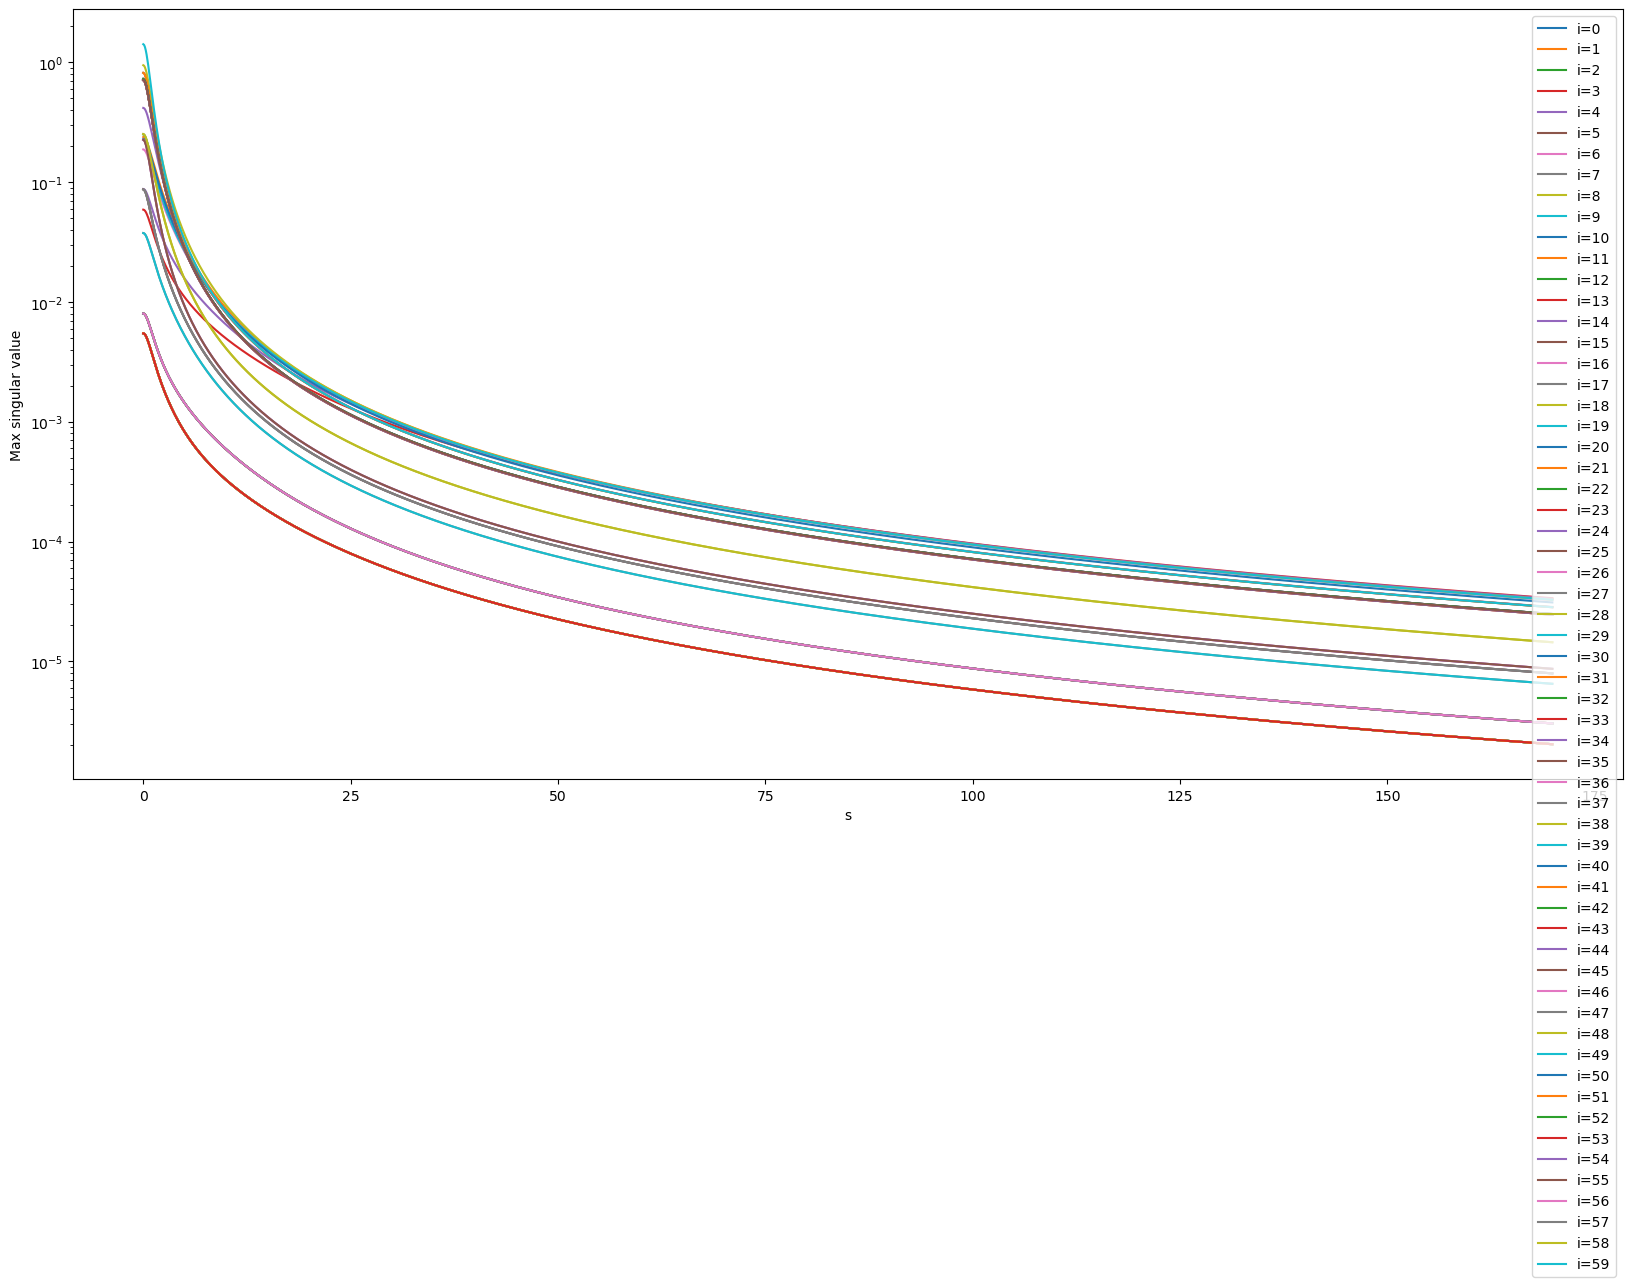

Dimenzija Laplaceove matrice:  60 
Dimenzija jezgre Laplaceove matrice:  42
Vrijeme izvršavanja:  0.03735470771789551 sec


In [108]:
i =0
plt.figure(figsize=(20,10))
start_time = time.time()
for obj in obj_values:
    plt.plot()
    plt.plot(s_range, obj, label = f"i={i}")
    i+=1;

end_time = time.time()
plt.xlabel('s')
plt.ylabel('Max singular value')
plt.yscale('log')
plt.legend()
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

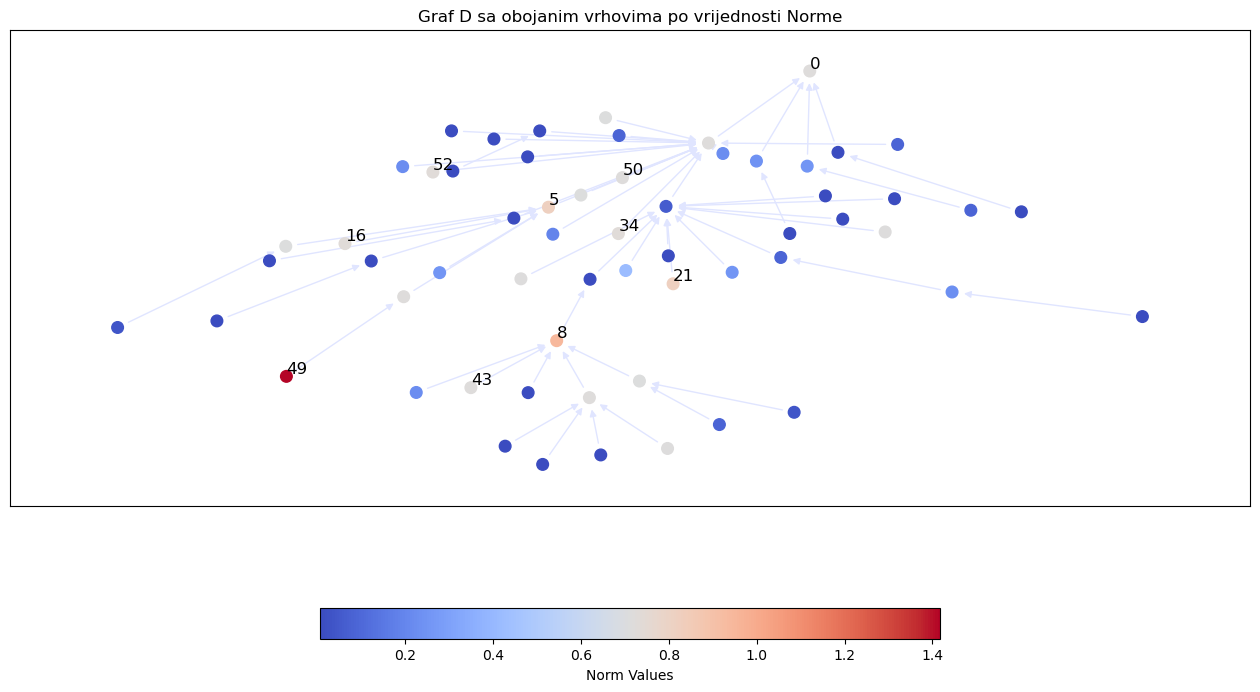

Dimenzija Laplaceove matrice:  60 
Dimenzija jezgre Laplaceove matrice:  42
Vrijeme izvršavanja:  0.03735470771789551 sec


In [109]:
# Plotanje grafa
plt.figure(figsize=(16,10))
pos = nx.spring_layout(Graph)
#node_labels = {n:norm_values[n] for n in Graph.nodes()}
#nx.draw(Graph,pos, node_color = node_colors, cmap = 'coolwarm', node_size=100)# labels = node_labels)
#plt.colorbar(label = 'Norm')
nodes = nx.draw_networkx_nodes(Graph, pos, node_color=norm_values, cmap='coolwarm', node_size=70)
edgclr = (224/255.0,229/255.0,255/255.0)
nx.draw_networkx_edges(Graph, pos,edge_color=edgclr)

#Odaberemo 10 vrhova s najvećom normom
largest_indices = np.argsort(norm_values)[-10:]
node_labels = {n: n for n in largest_indices}
nx.draw_networkx_labels(Graph, pos, labels=node_labels, font_color='black', verticalalignment='bottom', horizontalalignment='left')

# Odvojeni colorbar plot
cbar = plt.colorbar(nodes, label='Norm', orientation='horizontal', shrink=0.5)
cbar.ax.set_xlabel('Norm Values')
plt.subplots_adjust(bottom=0.2)  

plt.title('Graf D sa obojanim vrhovima po vrijednosti Norme')
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

Ovdje koristimo funkciju koja vraća normu vektora $||F_i(s)||$.

In [110]:
#def obj_fun(s):
 #   return -Fi(s)
Graph = D
sys_f, Kernel_dim, ndim, L_sigma = get_Fi_norm(Graph,alpha,beta,gamma)
    
alpha=1
beta=1
gamma=1

x0 = 0.1
left_end = 0
right_end = L_sigma*10
spacing = 0.1
bounds = [(left_end,right_end)]
s_range = np.arange(left_end,right_end, spacing)

obj_values = []
norm_values = []
norm0_values = []
start_time = time.time()
print("Trajanje Schurove dekompozicije:", time.time()-start_time)
for i in range(ndim):
    now = time.time()
    Fi = sys_f(i)
    res = minimize(Fi, x0, bounds=bounds, method='Nelder-Mead')
    #print(res)
    s_opt = res.x[0]
    norm = -res.fun
    norm_0 = Fi(0)
    #print(res.x, norm, "0",norm_0)
    #print(res.x, norm, "0",norm_0)
    obj_values.append([Fi(s) for s in s_range])
    norm_values.append(norm)
    norm0_values.append(norm_0)
    print("Trajanje ",i,"-te iteracije:", time.time()-now)
end_time = time.time()
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

Računam Schurovu dekompoziciju
Trajanje Schurove dekompozicije: 0.0
Trajanje  0 -te iteracije: 0.06743860244750977
Trajanje  1 -te iteracije: 0.048415184020996094
Trajanje  2 -te iteracije: 0.06258702278137207
Trajanje  3 -te iteracije: 0.06529426574707031
Trajanje  4 -te iteracije: 0.05443549156188965
Trajanje  5 -te iteracije: 0.04694366455078125
Trajanje  6 -te iteracije: 0.0625007152557373
Trajanje  7 -te iteracije: 0.05649828910827637
Trajanje  8 -te iteracije: 0.05141615867614746
Trajanje  9 -te iteracije: 0.047002315521240234
Trajanje  10 -te iteracije: 0.06250214576721191
Trajanje  11 -te iteracije: 0.05743265151977539
Trajanje  12 -te iteracije: 0.04987359046936035
Trajanje  13 -te iteracije: 0.047005414962768555
Trajanje  14 -te iteracije: 0.06250643730163574
Trajanje  15 -te iteracije: 0.05947709083557129
Trajanje  16 -te iteracije: 0.05282092094421387
Trajanje  17 -te iteracije: 0.0667414665222168
Trajanje  18 -te iteracije: 0.057216644287109375
Trajanje  19 -te iteracije: 

In [111]:
type(norm_values)

list

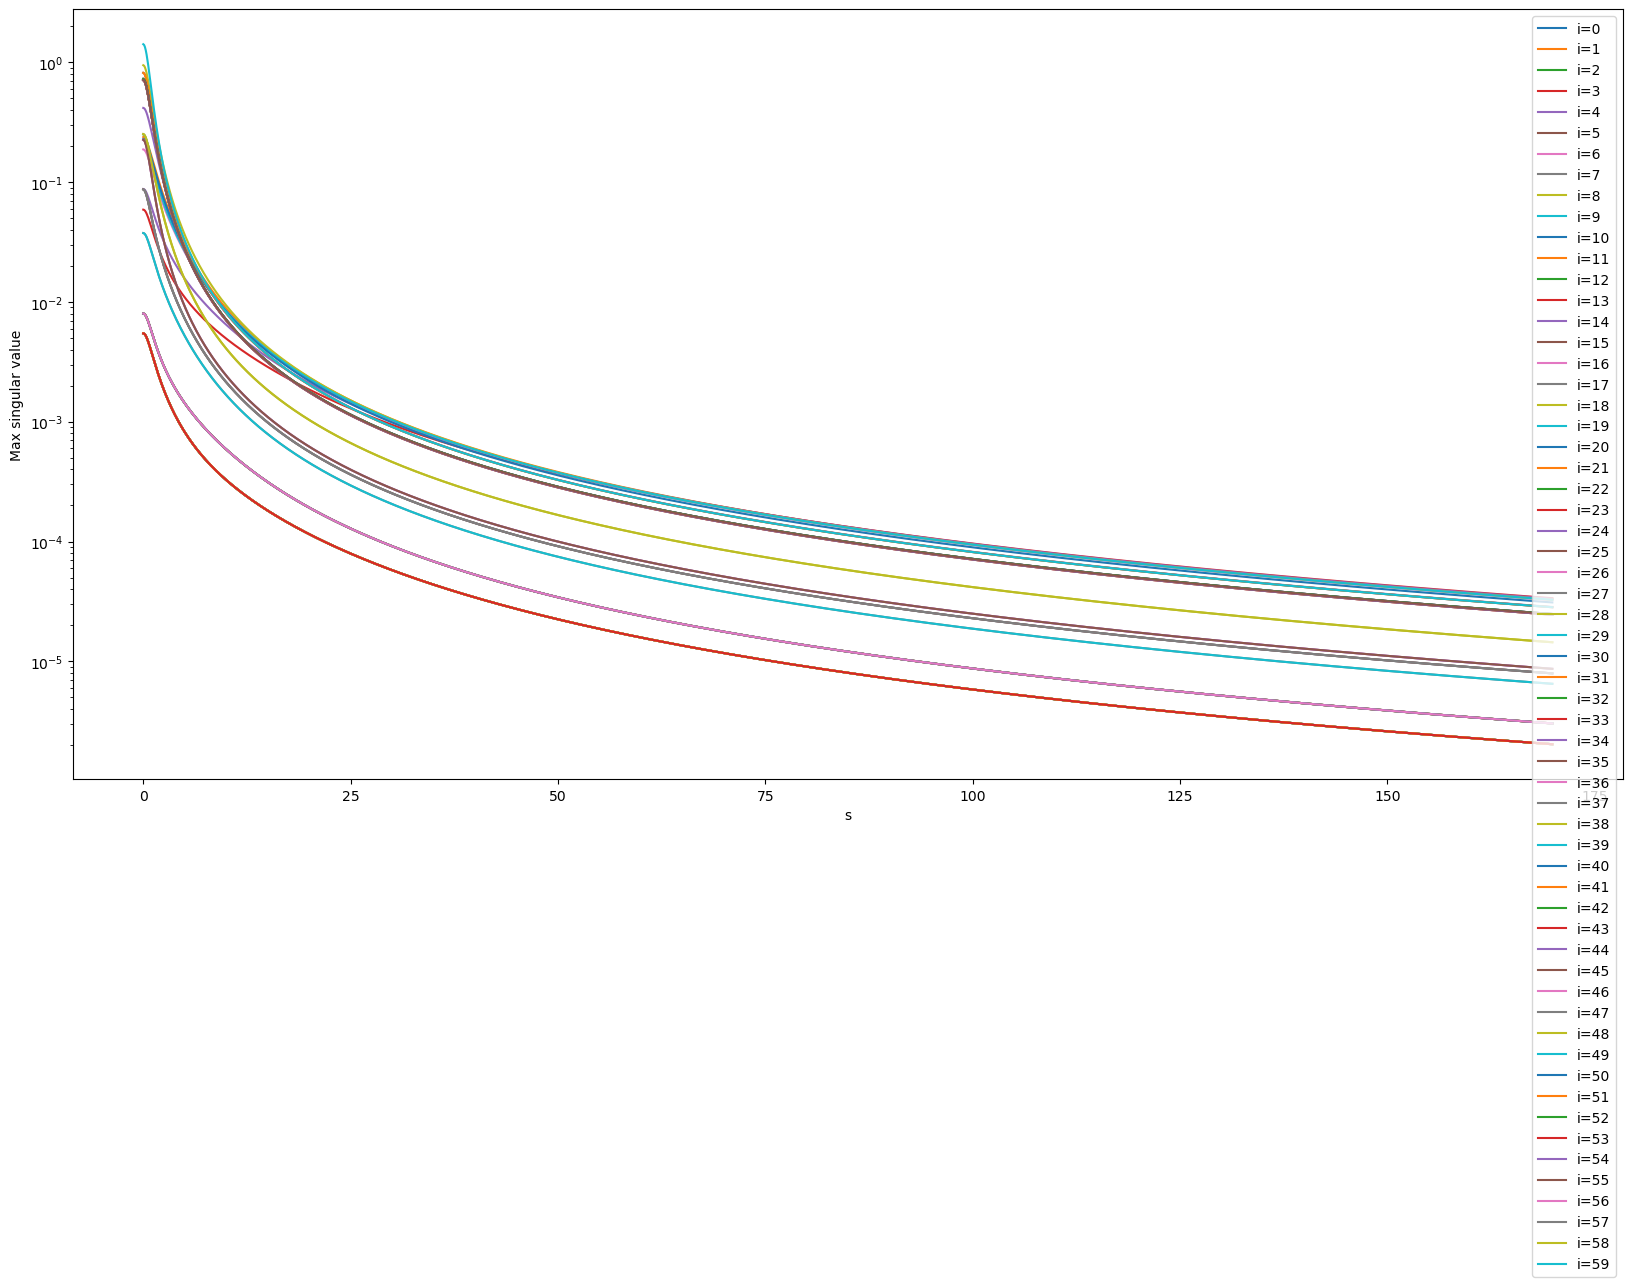

Dimenzija Laplaceove matrice:  60 
Dimenzija jezgre Laplaceove matrice:  42
Vrijeme izvršavanja:  0.04437732696533203 sec


In [112]:
i =0
plt.figure(figsize=(20,10))
start_time = time.time()
for obj in obj_values:
    plt.plot()
    plt.plot(s_range, obj, label = f"i={i}")
    i+=1;

end_time = time.time()
plt.xlabel('s')
plt.ylabel('Max singular value')
plt.yscale('log')
plt.legend()
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

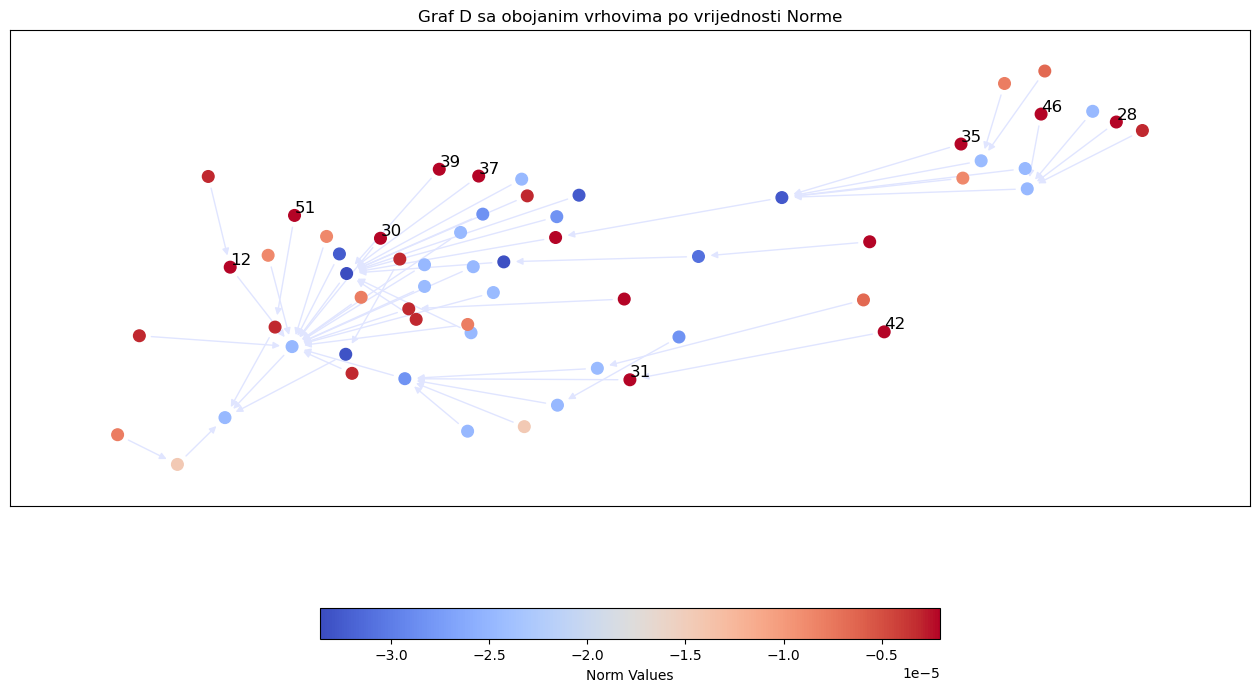

Dimenzija Laplaceove matrice:  60 
Dimenzija jezgre Laplaceove matrice:  42
Vrijeme izvršavanja:  0.04437732696533203 sec


In [113]:
# Plotanje grafa
plt.figure(figsize=(16,10))
pos = nx.spring_layout(Graph)
#node_labels = {n:norm_values[n] for n in Graph.nodes()}
#nx.draw(Graph,pos, node_color = node_colors, cmap = 'coolwarm', node_size=100)# labels = node_labels)
#plt.colorbar(label = 'Norm')
nodes = nx.draw_networkx_nodes(Graph, pos, node_color=norm_values, cmap='coolwarm', node_size=70)
edgclr = (224/255.0,229/255.0,255/255.0)
nx.draw_networkx_edges(Graph, pos,edge_color=edgclr)

#Odaberemo 10 vrhova s najvećom normom
largest_indices = np.argsort(norm_values)[-10:]
node_labels = {n: n for n in largest_indices}
nx.draw_networkx_labels(Graph, pos, labels=node_labels, font_color='black', verticalalignment='bottom', horizontalalignment='left')

# Odvojeni colorbar plot
cbar = plt.colorbar(nodes, label='Norm', orientation='horizontal', shrink=0.5)
cbar.ax.set_xlabel('Norm Values')
plt.subplots_adjust(bottom=0.2)  

plt.title('Graf D sa obojanim vrhovima po vrijednosti Norme')
plt.show()
print("Dimenzija Laplaceove matrice: ",ndim,"\nDimenzija jezgre Laplaceove matrice: ",Kernel_dim)
print("Vrijeme izvršavanja: ", end_time-start_time, "sec")

In [57]:
node_labels1 = [{n: n for n in largest_indices},{n: '{:.5e}'.format(norm_values[n]) for n in largest_indices}]
node_labels1

[{0: 0, 13: 13, 9: 9, 14: 14, 10: 10, 20: 20, 58: 58, 52: 52, 57: 57, 39: 39},
 {0: '-3.31711e-03',
  13: '-9.16923e-04',
  9: '-9.16923e-04',
  14: '-9.16923e-04',
  10: '-9.16923e-04',
  20: '-9.16923e-04',
  58: '-9.16923e-04',
  52: '-9.16923e-04',
  57: '-9.16923e-04',
  39: '-9.16923e-04'}]

In [ ]:
node_labels1[1][13]

'-9.16923e-04'